In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from scipy.integrate import odeint
from IPython.display import display, Latex

In [2]:
mpl.rcParams.update({'font.size':15})
param_names = ['$\\alpha_1$', '$\\beta_2$', '$\\beta_3$', '$d_1$', '$d_2$', '$d_3$', '$h_1$', '$K_1$', '$S_3$']
param_units = ['$mol. hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '$hr^{-1}$', '', '$mol.$', '$mol.$']
colors = ['#1f77b4','#ff7f0e','#2ca02c']

### Parameter Ranges
Original parameter ranges were obtained from Ananthasubramaniam et al. 2020. The parameters were then rescaled so the molecule concentrations were biologically realistic and had a period of 24 hours.

- $d_1, d_2, d_3$ (degradation)                0.1-0.3
- $h$             (Hill coefficient)           5-12
- $K$             (half-maximum concentration) 0.25-1
- $\tau$          (intrinsic period)           22-26


### Equations
$ \frac{dX}{dt} = \frac{\alpha_1}{1+(\frac{Z}{K_1})^{h_1}} - d_1X $ <br>
$ \frac{dY}{dt} = \beta_2 X - d_2Y $ <br>
$ \frac{dZ}{dt} = \beta_3 Y - \frac{d_3Z}{K_3+Z} $

X = Bmal1 mRNA <br>
Y = Rev-ErbA mRNA <br>
Z = Rev-ErbA protein <br>

In [3]:
def equations(xyz, t):
    """
    Originial equations from (Ananthasubramaniam2020). 
    First update by adding negative feedback on Y due to Z.
    Second update by changing degradation to saturation in Z.
    """
    x, y, z = xyz
    dx = a1/(1+(z/k1)**h1) - d1*x
    dy = b2*x - d2*y
    dz = b3*y - (d3*z)/(1+z/k3)
    return dx, dy, dz

### A simple example to start

alpha1 low


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


period = 13.913043478260871
Modulation Depth = 0.00


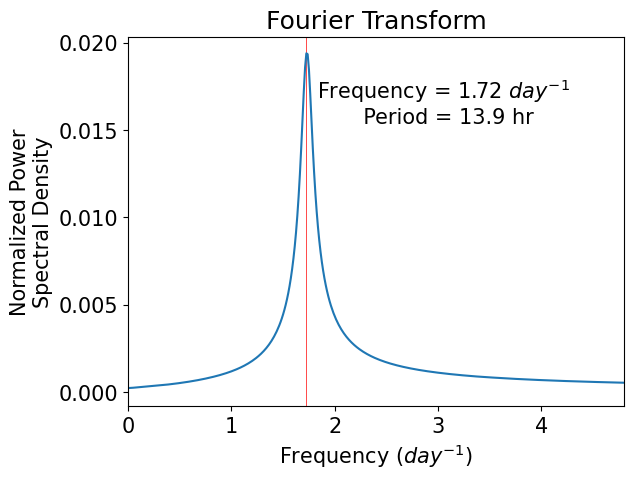

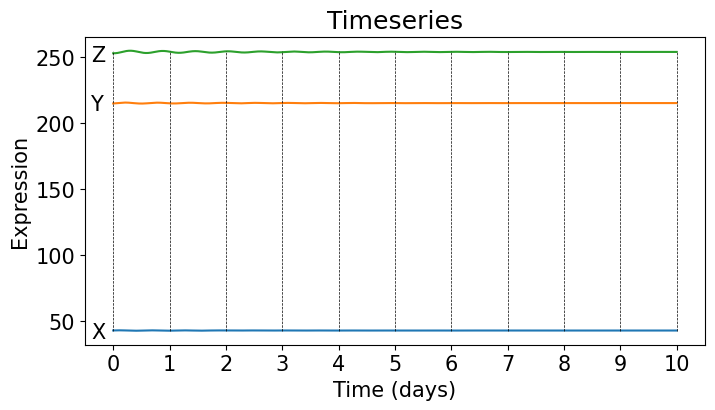


-----------------------------------------------------------------------------------------------------

alpha1 right


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


period = 24.0
Modulation Depth = 0.63


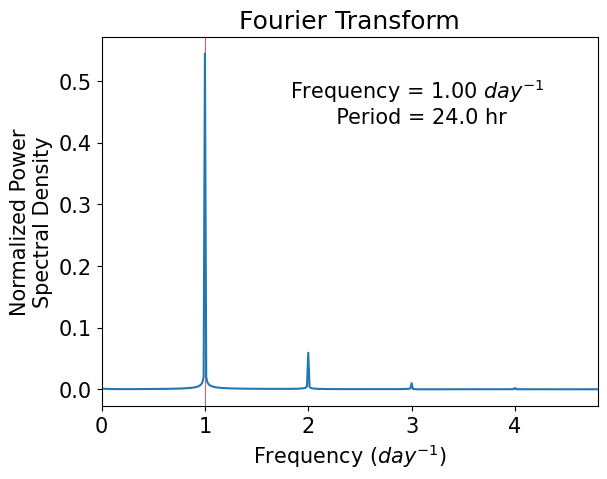

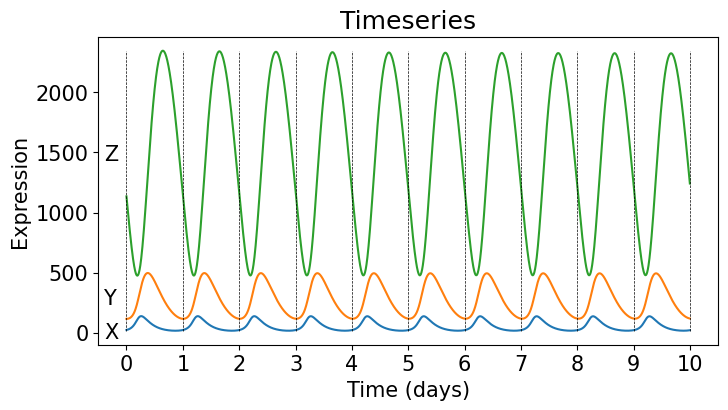


-----------------------------------------------------------------------------------------------------

alpha1 high


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


period = 26.666666666666668
Modulation Depth = 0.02


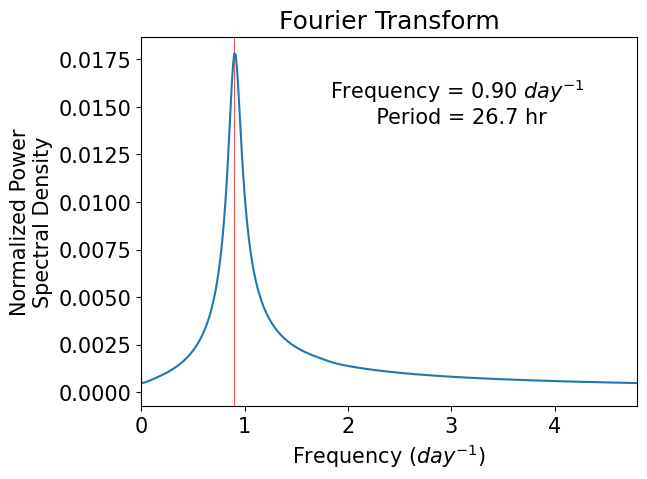

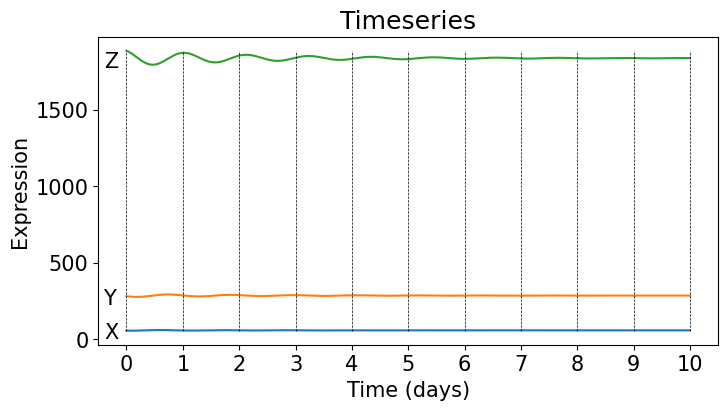


-----------------------------------------------------------------------------------------------------



In [7]:
# right case uses value of alpha1 that allows oscillations
# low and high cases use valus of alpha1 that disrupt oscillations

ly = {'high': [0.02, 0.13, 0.90],  # position for labels X,Y,Z on plot
       'right': [0.02, 0.13, 0.60],
       'low': [0.02, 0.76, 0.92]}
a1s = {'high':20000, 'right':5500, 'low':300}
rx, ry, rz, rt = [1,1,1,1]
handles = ['X', 'Y', 'Z']


for case in ['low','right','high']:
    
    print('alpha1',case)

    a1 = (rt/rx)*a1s[case]
    b2 = (rt*rx/ry)*1.3
    b3 = (rt*ry/rz)*1.3
    d1 = rt*0.26
    d2 = rt*0.26
    d3 = rt*3.9
    h1 = 2
    k1 = (1/rz)*50
    k3 = (1/rz)*100

    params = [a1, b2, b3, d1, d2, d3, h1, k1, k3]
    for i,par in enumerate(params):
        display(Latex(f'{{}} = {{}} {{}}'.format(param_names[i],par,param_units[i])))
    ### integrate the system using odeint
    days = 100 # number of days to run the simulation
    dStart = 20 # start day for plot
    dt = 0.1 # step size for integration with odeint
    init = [0,0,2] # initial points for X,Y,Z
    tvec = np.arange(0,24*days+dt,dt)
    tStart = 24*dStart # show oscillations after transient period
    tStop = tStart+24*(days-dStart) # days for fourier analysis
    tShow = tStart+24*10 # days to show in timeseries plot
    iStart = np.where(tvec>=tStart)[0][0]
    iStop = np.where(tvec>=tStop)[0][0]
    iShow = np.where(tvec>=tShow)[0][0]
    traj = odeint(equations, init, tvec)

    ### calculate the Fourier spectrum
    species = 2 # get Fourier spectrum for Z (Rev-ErbA protein)
    fdata = traj[iStart:iStop, species]
    tplot = tvec[iStart:iShow]
    yplot = traj[iStart:iShow]
    npts = len(tplot)
    ymin, ymax = np.min(fdata), np.max(fdata)
    xf = sp.fft.fftfreq(len(fdata), dt)[1:int(npts/2)] # remove huge peak at 0
    yf = sp.fft.fft(fdata)[1:int(npts/2)] # remove huge peak at 0
    xf_plot = xf*24
    yf_plot = np.abs(yf)/np.sum(np.abs(yf))

    ### peak for Fourier spectrum
    fig = plt.figure()
    ypeak = np.max(np.abs(yf))
    xpeak = xf[np.where(np.abs(yf)==ypeak)[0]]
    for pt in xpeak:
        plt.axvline(x=pt*24, linestyle='-', color='red', linewidth=0.5)
    freq = r'Frequency = {:.2f}'.format(pt*24) + r' $day^{-1}$'
    per = r'       Period = {:.1f} hr'.format(1/pt)
    pf_text = freq+"\n"+per

    plt.plot(xf_plot, yf_plot)
    plt.xlim([0,0.2*24])
    plt.xlabel('Frequency ($day^{-1}$)')
    plt.ylabel('Normalized Power\nSpectral Density')
    plt.title('Fourier Transform')
    plt.text(x=0.42, y=0.7, s=pf_text, transform=fig.transFigure)

    print('')
    print('period = {}'.format(1/pt))

    ### plot the timeseries for X,Y,Z
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ymin, ymax = np.min(yplot), np.max(yplot)
    for i in range(3):
        data = yplot[:,i]
        ax.plot(tplot, data, color=colors[i], label=handles[i])
        if i==2: # modulation depth of reverb-a
            rmin, rmax, ravg = np.min(data), np.max(data), np.mean(data)
            amp = (rmax-rmin)/2
            mod = amp/ravg
            print('Modulation Depth = {:.2f}'.format(mod))

    glines = np.arange(tplot[0], tplot[-1], 1/pt) # show strongest period
    glines = np.arange(tplot[0], tplot[-1]+24, 24)
    ax.vlines(glines, ymin, ymax, linestyles='--', color='black', linewidth=0.5)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Expression')
    ax.set_title('Timeseries')
    locs = np.arange(tStart, tShow+24, 24)
    labels = ((locs-locs[0])/24).astype(int) # scale to days instead of hours
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.text(x=0.01, y=ly[case][0], s='X', transform=ax.transAxes)
    ax.text(x=0.01, y=ly[case][1], s='Y', transform=ax.transAxes)
    ax.text(x=0.01, y=ly[case][2], s='Z', transform=ax.transAxes)
    plt.show()
    
    print('\n-----------------------------------------------------------------------------------------------------\n')

##### References

Bharath Ananthasubramaniam, Christoph Schmal, Hanspeter Herzel, Amplitude Effects Allow Short Jet Lags and Large Seasonal Phase Shifts in Minimal Clock Models, Journal of Molecular Biology, Volume 432, Issue 12, 2020, Pages 3722-3737, ISSN 0022-2836, https://doi.org/10.1016/j.jmb.2020.01.014.